In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from ncpol2sdpa import*

In [3]:
# read 
compas=pd.read_csv("compas-scores-two-years.csv")

# sampling
compas["screening_date"]=pd.to_datetime(compas["screening_date"])
compas["c_offense_date"]=pd.to_datetime(compas["c_offense_date"])
compas["r_offense_date"]=pd.to_datetime(compas["r_offense_date"])
compas=compas[(compas["two_year_recid"]==1) 
              &(compas["sex"]=="Male")&(compas["c_charge_degree"]=="M") &(compas["priors_count"]<=2)&(compas["age_cat"]=="25 - 45") ]
compas=compas[(compas["race"]== "African-American")|(compas["race"]== "Caucasian")]
compas=compas[(compas["r_charge_degree"]== "(M1)")|(compas["r_charge_degree"]== "(M2)") ]
length=compas.shape[0]
compas.index=[*range(length)]

# race 1 -> black
# race 0 -> white
for i in range(length):
    if compas.loc[i,"race"]=="Caucasian":
        compas.loc[i,"race"]=0
    elif compas.loc[i,"race"]=="African-American":
        compas.loc[i,"race"]=1
        
    # compute days_b_r_offense
    compas.loc[i,"days_b_r_offense"]=compas.loc[i,"r_offense_date"]-compas.loc[i,"c_offense_date"]

# convert days_b_r_offense to numbers
compas=compas.sort_values(by ="days_b_r_offense")
compas["days_b_r_offense"]=compas["days_b_r_offense"] / np.timedelta64(1, 's') /86400
compas=compas[(compas["days_b_r_offense"]>0)&(compas["days_b_r_offense"]<=730)]

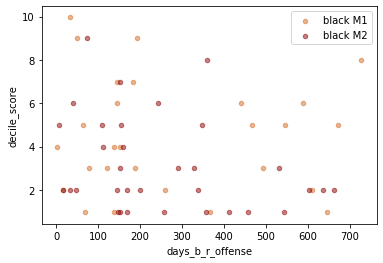

In [4]:
# plot black subgroup
ax=compas[(compas["race"]== 1)&(compas["r_charge_degree"]=="(M1)")].plot.scatter(x='days_b_r_offense', y='decile_score',label="black M1",color="chocolate",alpha=0.5)
compas[(compas["race"]== 1)&(compas["r_charge_degree"]=="(M2)")].plot.scatter(x='days_b_r_offense', y='decile_score',label="black M2",color="darkred",alpha=0.5,ax=ax)
#compas[(compas["race"]== 1)&(compas["r_charge_degree"]=="(F)")].plot.scatter(x='days_b_r_offense', y='decile_score',label="black F",color="darkred",alpha=0.5,ax=ax)

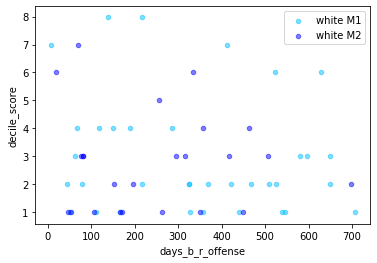

In [5]:
# plot white subgroup
ax=compas[(compas["race"]== 0)&(compas["r_charge_degree"]=="(M1)")].plot.scatter(x='days_b_r_offense', y='decile_score',label="white M1",color="deepskyblue",alpha=0.5)
compas[(compas["race"]== 0)&(compas["r_charge_degree"]=="(M2)")].plot.scatter(x='days_b_r_offense', y='decile_score',label="white M2",color="blue",alpha=0.5,ax=ax)
#compas[(compas["race"]== 0)&(compas["r_charge_degree"]=="(F)")].plot.scatter(x='days_b_r_offense', y='decile_score',label="white F",color="tab:blue",alpha=0.5,ax=ax)

In [6]:
# split into 4 trajectories

# black
roff1m1=compas[(compas["race"]== 1)&(compas["r_charge_degree"]=="(M1)")]
x1m1=np.array(roff1m1["days_b_r_offense"].tolist()).reshape(-1, 1)
y1m1=np.array(roff1m1["decile_score"].tolist())

roff1m2=compas[(compas["race"]== 1)&(compas["r_charge_degree"]=="(M2)") ]
x1m2=np.array(roff1m2["days_b_r_offense"].tolist()).reshape(-1, 1)
y1m2=np.array(roff1m2["decile_score"].tolist())

# white
roff0m1=compas[(compas["race"]== 0)&(compas["r_charge_degree"]=="(M1)")]
x0m1=np.array(roff0m1["days_b_r_offense"].tolist()).reshape(-1, 1)
y0m1=np.array(roff0m1["decile_score"].tolist())

roff0m2=compas[(compas["race"]== 0)&(compas["r_charge_degree"]=="(M2)")]
x0m2=np.array(roff0m2["days_b_r_offense"].tolist()).reshape(-1, 1)
y0m2=np.array(roff0m2["decile_score"].tolist())

# every 20 days becomes 1 period
T=30
leap=20
tra=np.zeros([T,5])
t=0
for i in range(T):
    sta=i*leap
    end=(i+1)*leap
    tratemp=np.zeros(4)
    # If at time t, there are more than 1 observation, take the average value.
    tratemp[0]=np.mean(roff1m1[(roff1m1["days_b_r_offense"]>=sta)&(roff1m1["days_b_r_offense"]<end)]['decile_score'].values)
    tratemp[1]=np.mean(roff1m2[(roff1m2["days_b_r_offense"]>=sta)&(roff1m2["days_b_r_offense"]<end)]['decile_score'].values)
    tratemp[2]=np.mean(roff0m1[(roff0m1["days_b_r_offense"]>=sta)&(roff0m1["days_b_r_offense"]<end)]['decile_score'].values)
    tratemp[3]=np.mean(roff0m2[(roff0m2["days_b_r_offense"]>=sta)&(roff0m2["days_b_r_offense"]<end)]['decile_score'].values)
    
    # There is still periods having not observation,which will be skipped
    if not (np.all(np.isnan(tratemp[0:2]))| np.all(np.isnan(tratemp[2:4]))):
        tra[t,1:5]=tratemp
        tra[t,0]=i
        t+=1
# Skip empty periods 
tra=tra[0:t-1,:]

C:\Users\zhouq\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\zhouq\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


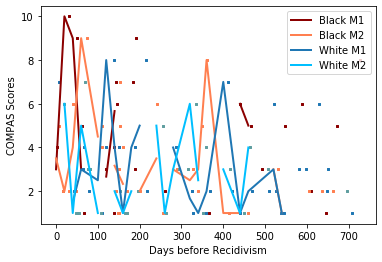

In [7]:
# Plot 4 trajectories
plt.scatter(x1m1, y1m1, color='darkred',s=3, marker="s")
plt.scatter(x1m2, y1m2, color='coral',s=3, marker="s")
plt.scatter(x0m1, y0m1, color='tab:blue',s=3, marker="s")
plt.scatter(x0m2, y0m2, color='cadetblue',s=3, marker="s")

plt.xlabel("Days before Recidivism")
plt.ylabel("COMPAS Scores")

plt.plot(tra[:,0]*20, tra[:,1], color='darkred',linewidth=2,label='Black M1')
plt.plot(tra[:,0]*20, tra[:,2], color='coral', linewidth=2,label='Black M2')

plt.plot(tra[:,0]*20, tra[:,3], color='tab:blue',linewidth=2,label='White M1')
plt.plot(tra[:,0]*leap, tra[:,4], color='deepskyblue', linewidth=2,label='White M2')

plt.legend()

In [9]:
# Apply Subgroup-Fair
# Parameters
level = 1
T = tra.shape[0]
group = 2
trajectory = [2,2]
sum_traj = sum(trajectory)
length=[sum(np.isnan(tra[:,i])*1) for i in range(1,5)]
ind1=[i for i in [*~np.isnan(tra[:,1])*range(T)] if i!=0]
ind2=[i for i in [*~np.isnan(tra[:,2])*range(T)] if i!=0]
ind3=[i for i in [*~np.isnan(tra[:,3])*range(T)] if i!=0]
ind4=[i for i in [*~np.isnan(tra[:,4])*range(T)] if i!=0]
# Decision Variables
G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
z = generate_operators("z", n_vars=1, hermitian=True, commutative=True)[0]
m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
p = generate_operators("p", n_vars=T, hermitian=True, commutative=True)
f = generate_operators("f", n_vars=T, hermitian=True, commutative=True)
# Constraints
ine1 = [f[i] - Fdash*m[i+1] - p[i] for i in range(T)]
ine2 = [-f[i] + Fdash*m[i+1] + p[i] for i in range(T)]
ine3 = [m[i+1] - G*m[i] - q[i] for i in range(T)]
ine4 = [-m[i+1] + G*m[i] + q[i] for i in range(T)]
max1=[z-1/length[0]*sum((tra[t,1]-f[t])**2 for t in ind1)-1/length[1]*sum((tra[t,2]-f[t])**2 for t in ind2)]
max2=[z-1/length[2]*sum((tra[t,3]-f[t])**2 for t in ind3)-1/length[3]*sum((tra[t,4]-f[t])**2 for t in ind4)]
ines_A = ine1+ine2+ine3+ine4+max1+max2
# Objective
obj_A = z + 1*sum(p[i]**2 for i in range(T)) 

# Solve the fair NCPO A
sdp_A = SdpRelaxation(variables = flatten([G,Fdash,z,f,p,m,q]), verbose = 2)
sdp_A.get_relaxation(level, objective=obj_A, inequalities=ines_A)
sdp_A.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
print(sdp_A.primal, sdp_A.dual, sdp_A.status)

foreA=[]
for t in range(T):
    foreA.append(sdp_A[f[t]])

The problem has 43 commuting, 45 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 4004
Generating moment matrix...
Reduced number of SDP variables: 4004004 (done: 100.02%, ETA 00:00:-0.0)
Processing 86/86 constraints...
23.514689265766318 23.475669205676517 unknown


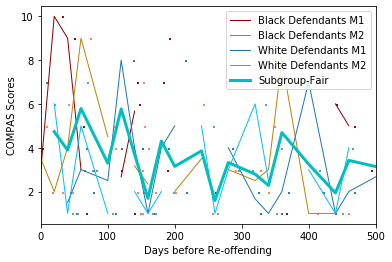

In [12]:
# Plot outputs
plt.scatter(x1m1, y1m1, color='darkred',s=1, marker="s")
plt.scatter(x1m2, y1m2, color='coral',s=1, marker="s")
plt.scatter(x0m1, y0m1, color='tab:blue',s=1, marker="s")
plt.scatter(x0m2, y0m2, color='cadetblue',s=1, marker="s")

plt.xlabel("Days before Re-offending")
plt.ylabel("COMPAS Scores")

plt.plot(tra[:,0]*leap, tra[:,1], color='darkred',linewidth=1,label='Black Defendants M1')
plt.plot(tra[:,0]*leap, tra[:,2], color='darkgoldenrod', linewidth=1,label='Black Defendants M2')

plt.plot(tra[:,0]*leap, tra[:,3], color='tab:blue',linewidth=1,label='White Defendants M1')
plt.plot(tra[:,0]*leap, tra[:,4], color='deepskyblue', linewidth=1,label='White Defendants M2')

plt.plot(tra[1:T,0]*leap, foreA[1:T], color='c', linewidth=3,label='Subgroup-Fair')

plt.xlim([0,500])
plt.legend()

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.savefig('CompasPlot2.pdf', bbox_inches='tight')